In [ ]:
%pip install gpxpy geopandas contextily matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 87.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import xml.etree.ElementTree as ET

tree = ET.parse('/content/ninh_binh_taxi_matched.gpx')
root = tree.getroot()
ns = {'default': 'http://www.topografix.com/GPX/1/1'}

data = []
for trkpt in root.findall('.//default:trkpt', ns):
    lat = float(trkpt.attrib['lat'])
    lon = float(trkpt.attrib['lon'])
    time_elem = trkpt.find('default:time', ns)
    if time_elem is not None:
        # clean the timestamp: remove redundant '+00:00Z'
        time_str = time_elem.text.replace('+00:00Z', 'Z')
        time_val = pd.to_datetime(time_str)
    else:
        time_val = None
    data.append({'latitude': lat, 'longitude': lon, 'time': time_val})

df = pd.DataFrame(data)
df.head()

,latitude,longitude,time
0,20.287325,105.862660,2025-10-18 12:44:09+00:00
1,20.288070,105.862758,2025-10-18 12:44:15+00:00
2,20.289868,105.863037,2025-10-18 12:44:27+00:00
3,20.291069,105.863318,2025-10-18 12:44:34+00:00
4,20.292038,105.863545,2025-10-18 12:44:40+00:00


In [ ]:
from geopy.distance import geodesic

def calc_distance(row):
    if pd.isna(row['prev_lat']):
        return 0
    return geodesic(
        (row['prev_lat'], row['prev_lon']),
        (row['latitude'], row['longitude'])
    ).km

df['prev_lat'] = df['latitude'].shift(1)
df['prev_lon'] = df['longitude'].shift(1)

df['distance_km'] = df.apply(calc_distance, axis=1)
df['time_diff_h'] = df['time'].diff().dt.total_seconds() / 3600
df['speed_kmh'] = df['distance_km'] / df['time_diff_h']

df = df.drop(columns=['prev_lat', 'prev_lon', 'time_diff_h'])

df.head()

,latitude,longitude,time,speed_kmh,distance_km
1,20.288070,105.862758,2025-10-18 12:44:15+00:00,NaN,0.000000
2,20.289868,105.863037,2025-10-18 12:44:27+00:00,60.352469,0.201175
3,20.291069,105.863318,2025-10-18 12:44:34+00:00,70.025877,0.136161
4,20.292038,105.863545,2025-10-18 12:44:40+00:00,65.919073,0.109865
5,20.292622,105.863677,2025-10-18 12:44:43+00:00,79.328714,0.066107


In [ ]:
df['speed_kmh'].describe()

,speed_kmh
count,185.000000
mean,62.838815
std,21.921027
min,18.017385
25%,49.118610
50%,61.344093
75%,74.993250
max,176.482837


In [ ]:
Q1 = df['speed_kmh'].quantile(0.25)
Q3 = df['speed_kmh'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df = df[(df['speed_kmh'] >= lower_bound) & (df['speed_kmh'] <= upper_bound)]
df['speed_kmh'].describe()

,speed_kmh
count,182.000000
mean,61.411656
std,18.736715
min,18.017385
25%,48.482609
50%,60.702537
75%,74.365093
max,108.108522


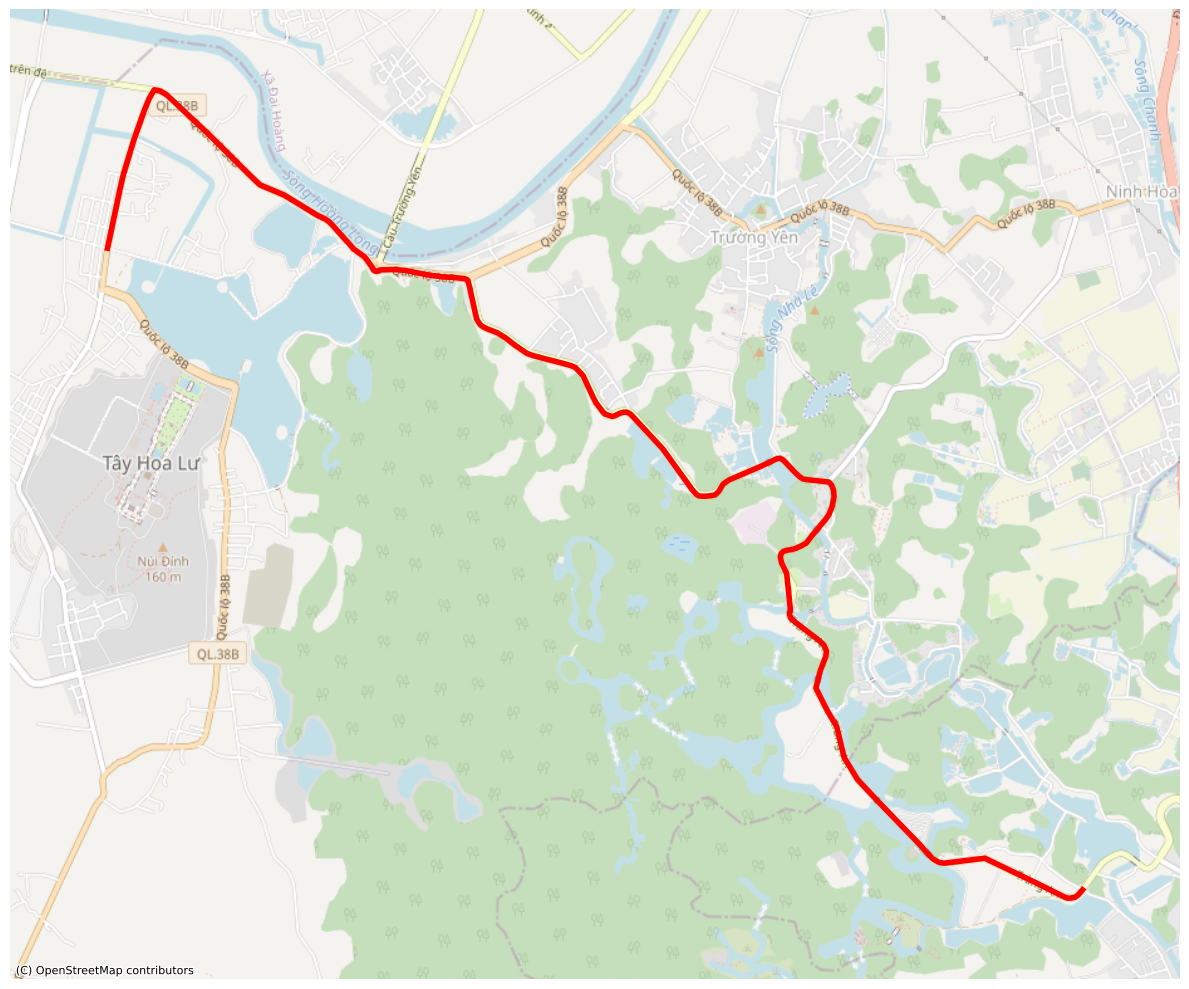

In [63]:
import matplotlib.pyplot as plt
from pyproj import Transformer
import numpy as np

# Transform coordinates from EPSG:4326 to EPSG:3857 (Web Mercator)
transformer = Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True)
x, y = transformer.transform(df['longitude'].values, df['latitude'].values)

# Handle NaNs by interpolating or dropping (to make line continuous)
valid_idx = ~np.isnan(x) & ~np.isnan(y)
x = x[valid_idx]
y = y[valid_idx]

# Create figure
fig, ax = plt.subplots(figsize=(12, 10))

if len(x) > 1:
    # Plot thick red line for the route
    ax.plot(x, y, color='red', linewidth=4, zorder=2)
else:
    # Single point
    ax.scatter(x, y, color='red', s=100, zorder=5)

# Set axis limits based on data
margin = 0.1
x_range = x.max() - x.min()
y_range = y.max() - y.min()
ax.set_xlim(x.min() - margin * x_range, x.max() + margin * x_range)
ax.set_ylim(y.min() - margin * y_range, y.max() + margin * y_range)

# Optional basemap (dim appearance)
import contextily as ctx
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, zoom='auto', alpha=0.7)

# Styling
ax.set_axis_off()
plt.tight_layout()
plt.show()


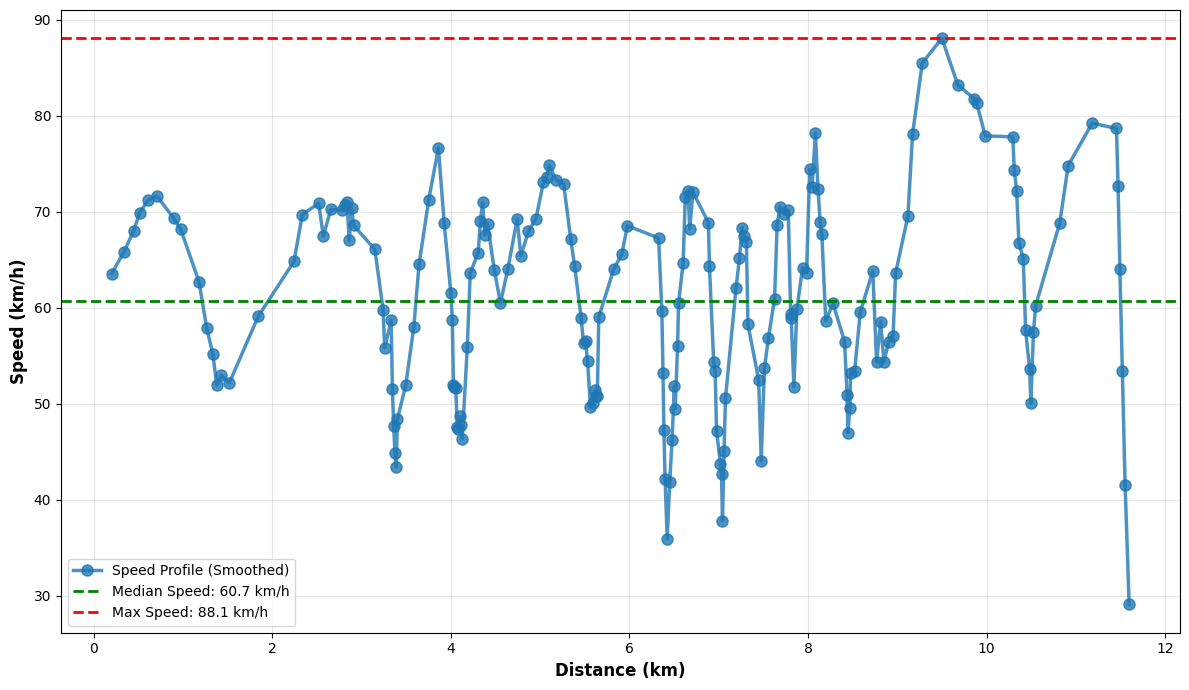

In [ ]:
import numpy as np
from scipy.signal import savgol_filter

# Calculate cumulative distance
df['cumulative_distance_km'] = df['distance_km'].cumsum()

# Apply Savitzky-Golay polynomial smoothing with larger window for more smoothing
window_length = min(11, len(df) if len(df) % 2 == 1 else len(df) - 1)  # Must be odd and <= data length
polyorder = min(3, window_length - 1)  # Must be less than window_length
df['speed_smoothed'] = savgol_filter(df['speed_kmh'], window_length=window_length, polyorder=polyorder)

# Calculate statistics (median from original, max from smoothed)
median_speed = df['speed_kmh'].median()
max_speed = df['speed_smoothed'].max()

# Create the plot
plt.figure(figsize=(12, 7))

# Plot smoothed speed only
plt.plot(df['cumulative_distance_km'], df['speed_smoothed'],
         marker='o', markersize=8, linewidth=2.5, alpha=0.8,
         label='Speed Profile (Smoothed)')

# Add horizontal lines for statistics
plt.axhline(median_speed, color='green', linestyle='--', linewidth=2,
            label=f'Median Speed: {median_speed:.1f} km/h')
plt.axhline(max_speed, color='red', linestyle='--', linewidth=2,
            label=f'Max Speed: {max_speed:.1f} km/h')

# Labels and title
plt.xlabel('Distance (km)', fontsize=12, fontweight='bold')
plt.ylabel('Speed (km/h)', fontsize=12, fontweight='bold')
plt.legend(loc='best', fontsize=10)
plt.grid(True, alpha=0.3)

# Display the plot
plt.tight_layout()
plt.show()

In [64]:
import pandas as pd
import xml.etree.ElementTree as ET

tree = ET.parse('/content/ninh_binh_taxi_ride.gpx')
root = tree.getroot()
ns = {'default': 'http://www.topografix.com/GPX/1/1'}

data = []
for trkpt in root.findall('.//default:trkpt', ns):
    lat = float(trkpt.attrib['lat'])
    lon = float(trkpt.attrib['lon'])
    time_elem = trkpt.find('default:time', ns)
    if time_elem is not None:
        # clean the timestamp: remove redundant '+00:00Z'
        time_str = time_elem.text.replace('+00:00Z', 'Z')
        time_val = pd.to_datetime(time_str)
    else:
        time_val = None
    data.append({'latitude': lat, 'longitude': lon, 'time': time_val})

df = pd.DataFrame(data)

from geopy.distance import geodesic

def calc_distance(row):
    if pd.isna(row['prev_lat']):
        return 0
    return geodesic(
        (row['prev_lat'], row['prev_lon']),
        (row['latitude'], row['longitude'])
    ).km

df['prev_lat'] = df['latitude'].shift(1)
df['prev_lon'] = df['longitude'].shift(1)

df['distance_km'] = df.apply(calc_distance, axis=1)
df['time_diff_h'] = df['time'].diff().dt.total_seconds() / 3600
df['speed_kmh'] = df['distance_km'] / df['time_diff_h']

df = df.drop(columns=['prev_lat', 'prev_lon', 'time_diff_h'])

Q1 = df['speed_kmh'].quantile(0.25)
Q3 = df['speed_kmh'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df = df[(df['speed_kmh'] >= lower_bound) & (df['speed_kmh'] <= upper_bound)]
df['speed_kmh'].describe()

,speed_kmh
count,836.000000
mean,61.007361
std,14.064397
min,18.304740
25%,51.810842
50%,62.918511
75%,70.875132
max,101.415112


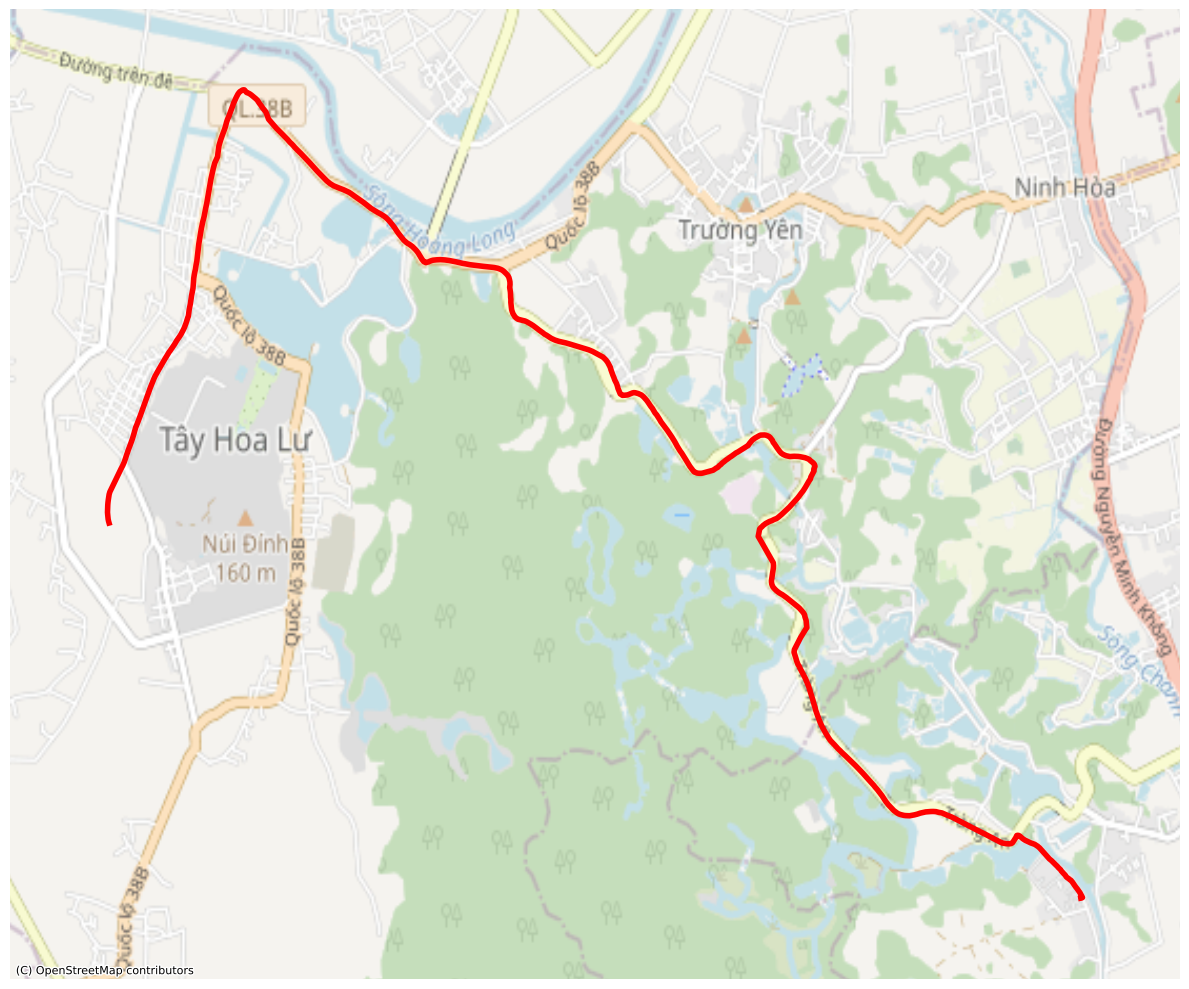

In [65]:
import matplotlib.pyplot as plt
from pyproj import Transformer
import numpy as np

# Transform coordinates from EPSG:4326 to EPSG:3857 (Web Mercator)
transformer = Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True)
x, y = transformer.transform(df['longitude'].values, df['latitude'].values)

# Handle NaNs by interpolating or dropping (to make line continuous)
valid_idx = ~np.isnan(x) & ~np.isnan(y)
x = x[valid_idx]
y = y[valid_idx]

# Create figure
fig, ax = plt.subplots(figsize=(12, 10))

if len(x) > 1:
    # Plot thick red line for the route
    ax.plot(x, y, color='red', linewidth=4, zorder=2)
else:
    # Single point
    ax.scatter(x, y, color='red', s=100, zorder=5)

# Set axis limits based on data
margin = 0.1
x_range = x.max() - x.min()
y_range = y.max() - y.min()
ax.set_xlim(x.min() - margin * x_range, x.max() + margin * x_range)
ax.set_ylim(y.min() - margin * y_range, y.max() + margin * y_range)

# Optional basemap (dim appearance)
import contextily as ctx
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, zoom='auto', alpha=0.7)

# Styling
ax.set_axis_off()
plt.tight_layout()
plt.show()


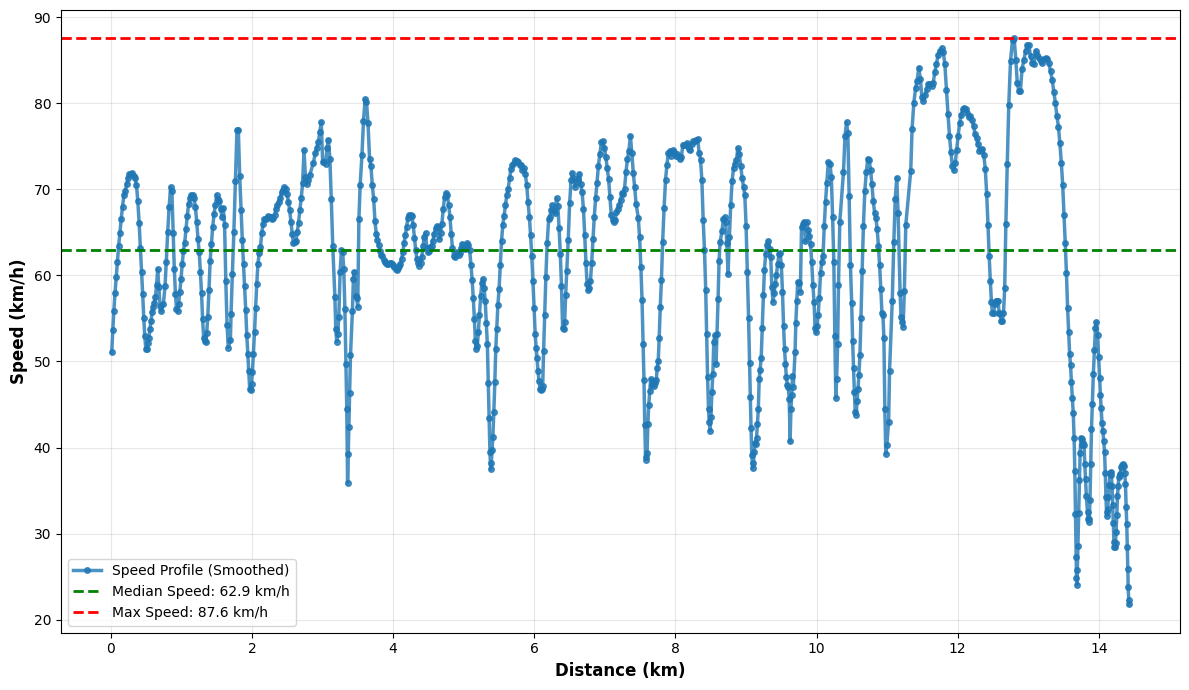

In [70]:
import numpy as np
from scipy.signal import savgol_filter

# Calculate cumulative distance
df['cumulative_distance_km'] = df['distance_km'].cumsum()

# Apply Savitzky-Golay polynomial smoothing with larger window for more smoothing
window_length = min(11, len(df) if len(df) % 2 == 1 else len(df) - 1)  # Must be odd and <= data length
polyorder = min(3, window_length - 1)  # Must be less than window_length
df['speed_smoothed'] = savgol_filter(df['speed_kmh'], window_length=window_length, polyorder=polyorder)

# Calculate statistics (median from original, max from smoothed)
median_speed = df['speed_kmh'].median()
max_speed = df['speed_smoothed'].max()

# Create the plot
plt.figure(figsize=(12, 7))

# Plot smoothed speed only
plt.plot(df['cumulative_distance_km'], df['speed_smoothed'],
         marker='o', markersize=4, linewidth=2.5, alpha=0.8,
         label='Speed Profile (Smoothed)')

# Add horizontal lines for statistics
plt.axhline(median_speed, color='green', linestyle='--', linewidth=2,
            label=f'Median Speed: {median_speed:.1f} km/h')
plt.axhline(max_speed, color='red', linestyle='--', linewidth=2,
            label=f'Max Speed: {max_speed:.1f} km/h')

# Labels and title
plt.xlabel('Distance (km)', fontsize=12, fontweight='bold')
plt.ylabel('Speed (km/h)', fontsize=12, fontweight='bold')
plt.legend(loc='best', fontsize=10)
plt.grid(True, alpha=0.3)

# Display the plot
plt.tight_layout()
plt.show()